In [38]:
import pandas as pd
import geopandas as gpd

In [39]:
df =pd.read_csv('data.csv')

In [40]:
#rename the second row to be the header
df.columns = df.iloc[1]

# Step 2: Drop the first row since it's now the header
df = df[2:].reset_index(drop=True)

In [41]:
# Step 3: Drop the first three rows and reset the index
df = df.drop(index=[0, 1, 2]).reset_index(drop=True)
df = df.iloc[:-2].reset_index(drop=True)


In [42]:
# Rename columns by position
df.columns.values[2] = 'state'        # 3rd column (index 2)
df.columns.values[8] = 'Hindu_F'      # 9th column (index 8)
df.columns.values[10] = 'Muslim_F'    # 11th column (index 10)
df.columns.values[12] = 'Christian_F' # 13th column (index 12)
df.columns.values[14] = 'Sikh_F'      # 15th column (index 14)
df.columns.values[16] = 'Buddhist_F'  # 17th column (index 16)
df.columns.values[18] = 'Jain_F'      # 19th column (index 18)
df.columns.values[20] = 'Others_F'    # 21st column (index 20)


In [43]:
df = df[df.code != '00']
df = df[df["hold size"]== 'Total']
df= df[df['Rural/Urban'] == 'Total']

In [44]:
# Ensure numeric (optional if already numbers)
religion_cols = ['Hindu', 'Hindu_F', 'Muslim', 'Muslim_F', 'Christian', 'Christian_F',
                 'Sikh', 'Sikh_F', 'Buddhist', 'Buddhist_F', 'Jain', 'Jain_F', 'Others', 'Others_F']

df[religion_cols] = df[religion_cols].apply(pd.to_numeric, errors='coerce')
df['Hindu_Total'] = df['Hindu'] + df['Hindu_F']
df['Muslim_Total'] = df['Muslim'] + df['Muslim_F']
df['Christian_Total'] = df['Christian'] + df['Christian_F']
df['Sikh_Total'] = df['Sikh'] + df['Sikh_F']
df['Buddhist_Total'] = df['Buddhist'] + df['Buddhist_F']
df['Jain_Total'] = df['Jain'] + df['Jain_F']
df['Others_Total'] = df['Others'] + df['Others_F']
df[['Male head', 'Female head']] = df[['Male head', 'Female head']].apply(pd.to_numeric, errors='coerce')
df['total'] = df['Male head'].fillna(0) + df['Female head'].fillna(0)

# Calculate religion percentages
df['Hindu_Pct'] = (df['Hindu_Total'] / df['total']) * 100
df['Muslim_Pct'] = (df['Muslim_Total'] / df['total']) * 100
df['Christian_Pct'] = (df['Christian_Total'] / df['total']) * 100
df['Sikh_Pct'] = (df['Sikh_Total'] / df['total']) * 100
df['Buddhist_Pct'] = (df['Buddhist_Total'] / df['total']) * 100
df['Jain_Pct'] = (df['Jain_Total'] / df['total']) * 100
df['Others_Pct'] = (df['Others_Total'] / df['total']) * 100


In [45]:
import re

# Use regex to clean 'state' column
df['state_clean'] = df['state'].str.replace(r'^(State|Union Territory) - ', '', regex=True)
df['state_clean'] = df['state_clean'].str.replace(r'\s*\(\d+\)$', '', regex=True).str.strip()


In [46]:
pip install geopandas matplotlib



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [47]:
df.state_clean.unique()

array(['JAMMU & KASHMIR', 'HIMACHAL PRADESH', 'PUNJAB', 'CHANDIGARH',
       'UTTARAKHAND', 'HARYANA', 'NCT OF DELHI', 'RAJASTHAN',
       'UTTAR PRADESH', 'BIHAR', 'SIKKIM', 'ARUNACHAL PRADESH',
       'NAGALAND', 'MANIPUR', 'MIZORAM', 'TRIPURA', 'MEGHALAYA', 'ASSAM',
       'WEST BENGAL', 'JHARKHAND', 'ODISHA', 'CHHATTISGARH',
       'MADHYA PRADESH', 'GUJARAT', 'DAMAN & DIU', 'DADRA & NAGAR HAVELI',
       'MAHARASHTRA', 'ANDHRA PRADESH', 'KARNATAKA', 'GOA', 'LAKSHADWEEP',
       'KERALA', 'TAMIL NADU', 'PUDUCHERRY', 'ANDAMAN & NICOBAR ISLANDS'],
      dtype=object)

In [48]:
# Mapping for mismatches
state_name_mapping = {
    'NCT OF DELHI': 'DELHI',
    'ANDAMAN & NICOBAR ISLANDS': 'ANDAMAN & NICOBAR'
}

# Apply mapping
df['state_clean'] = df['state_clean'].replace(state_name_mapping)


In [49]:
gdf = gpd.read_file("INDIA_STATES.geojson")


# Replace STNAME values to merge
gdf['STNAME'] = gdf['STNAME'].replace({
    'LADAKH': 'JAMMU & KASHMIR',
    'TELANGANA': 'ANDHRA PRADESH'
})

# Dissolve rows with same state name into a single geometry
gdf_merged = gdf.dissolve(by='STNAME', as_index=False)


In [50]:
# merge dataframes on state names
final = gdf_merged.merge(df, left_on='STNAME', right_on='state_clean')


In [51]:
# Define dictionary of religion totals
religion_totals = {
    'Hindu_Total': 'Hindu',
    'Muslim_Total': 'Muslim',
    'Christian_Total': 'Christian',
    'Sikh_Total': 'Sikh',
    'Buddhist_Total': 'Buddhist',
    'Jain_Total': 'Jain',
    'Others_Total': 'Others'
}

# Create a DataFrame with just the religion totals
religion_df = final[list(religion_totals.keys())]

# Get second largest religion name per row
final['Second_Biggest_Religion'] = religion_df.apply(
    lambda row: row.sort_values(ascending=False).index[1], axis=1
)

# Convert column name to readable religion name
final['Second_Biggest_Religion'] = final['Second_Biggest_Religion'].map(religion_totals)


In [52]:
final.Second_Biggest_Religion.unique()

array(['Christian', 'Muslim', 'Sikh', 'Hindu', 'Others', 'Buddhist'],
      dtype=object)

In [53]:
final.columns

Index(['STNAME', 'geometry', 'STCODE11', 'STNAME_SH', 'Shape_Length',
       'Shape_Area', 'OBJECTID_1', 'OBJECTID', 'State_LGD', 'Shape_Leng',
       'MaxSimpTol', 'MinSimpTol', 'name', 'code', 'state', 'Rural/Urban',
       'hold size', 'Male head', 'Female head', 'Hindu', 'Hindu_F', 'Muslim',
       'Muslim_F', 'Christian', 'Christian_F', 'Sikh', 'Sikh_F', 'Buddhist',
       'Buddhist_F', 'Jain', 'Jain_F', 'Others', 'Others_F', 'Hindu_Total',
       'Muslim_Total', 'Christian_Total', 'Sikh_Total', 'Buddhist_Total',
       'Jain_Total', 'Others_Total', 'total', 'Hindu_Pct', 'Muslim_Pct',
       'Christian_Pct', 'Sikh_Pct', 'Buddhist_Pct', 'Jain_Pct', 'Others_Pct',
       'state_clean', 'Second_Biggest_Religion'],
      dtype='object')

DataFrame shape: (35, 50)
Columns: ['STNAME', 'geometry', 'STCODE11', 'STNAME_SH', 'Shape_Length', 'Shape_Area', 'OBJECTID_1', 'OBJECTID', 'State_LGD', 'Shape_Leng', 'MaxSimpTol', 'MinSimpTol', 'name', 'code', 'state', 'Rural/Urban', 'hold size', 'Male head', 'Female head', 'Hindu', 'Hindu_F', 'Muslim', 'Muslim_F', 'Christian', 'Christian_F', 'Sikh', 'Sikh_F', 'Buddhist', 'Buddhist_F', 'Jain', 'Jain_F', 'Others', 'Others_F', 'Hindu_Total', 'Muslim_Total', 'Christian_Total', 'Sikh_Total', 'Buddhist_Total', 'Jain_Total', 'Others_Total', 'total', 'Hindu_Pct', 'Muslim_Pct', 'Christian_Pct', 'Sikh_Pct', 'Buddhist_Pct', 'Jain_Pct', 'Others_Pct', 'state_clean', 'Second_Biggest_Religion']
Second_Biggest_Religion: Second_Biggest_Religion
Muslim       18
Christian     8
Hindu         5
Buddhist      2
Sikh          1
Others        1
Name: count, dtype: int64
              STNAME_SH Second_Biggest_Religion
0     Andaman & Nicobar               Christian
1             Telangana                  Mu

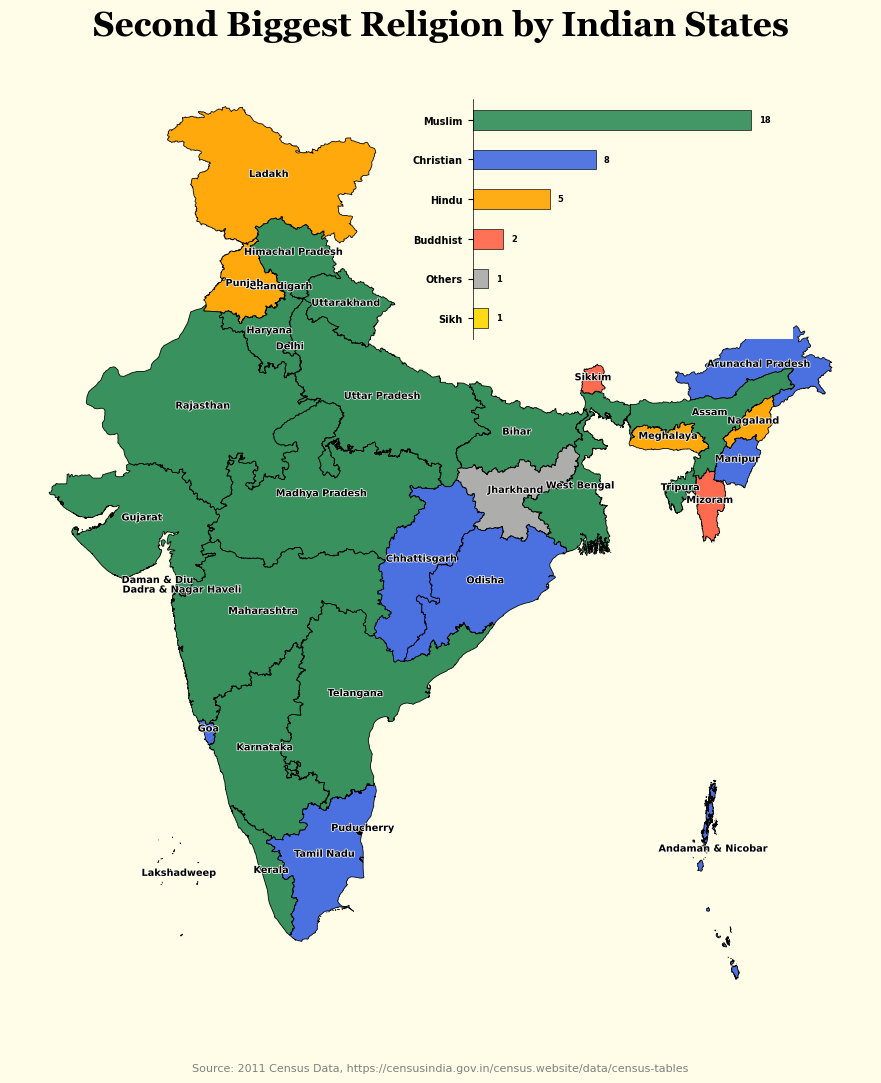

In [54]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import matplotlib.patheffects as path_effects
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set color palette
sns.set_palette("husl")
plt.style.use('default')

def create_religion_map(final_df):
    # Define religion colors
    religion_colors = {
        'Hindu': '#FFA500',
        'Muslim': '#2E8B57',
        'Christian': '#4169E1',
        'Sikh': '#FFD700',
        'Buddhist': '#FF6347',
        'Jain': '#708090',
        'Others': '#A9A9A9',
        'Other': '#A9A9A9',
        'No Religion': '#D3D3D3',
        'Not Stated': '#D3D3D3'
    }

    # Create figure
    fig = plt.figure(figsize=(16, 12))
    fig.patch.set_facecolor('#fffde7')  # Light background

    # Main map axis
    ax_map = plt.axes([0.05, 0.05, 0.9, 0.8])
    ax_map.set_facecolor('#fffde7')

    # Plot states with appropriate colors
    colors = final_df['Second_Biggest_Religion'].map(lambda x: religion_colors.get(x, '#D3D3D3'))
    final_df.plot(
        ax=ax_map,
        color=colors,
        edgecolor='black',
        linewidth=0.6,
        alpha=0.95
    )

    # Add short state name annotations
    for _, row in final_df.iterrows():
        if pd.notnull(row['STNAME_SH']):
            point = row['geometry'].centroid
            ax_map.text(point.x, point.y, row['STNAME_SH'],
                        ha='center', fontsize=7, fontweight='bold', color='black',
                        path_effects=[path_effects.withStroke(linewidth=1, foreground="white")])

    # Title
    ax_map.set_title(
        'Second Biggest Religion by Indian States',
        fontsize=24, fontweight='bold', fontname='Georgia', pad=20
    )
    ax_map.set_axis_off()

    # ===== BAR CHART =====
    ax_bar = plt.axes([0.52, 0.62, 0.20, 0.20])  # repositioned for better layout
    religion_counts = final_df['Second_Biggest_Religion'].value_counts().sort_values(ascending=True)

    sorted_religions = religion_counts.index.tolist()
    sorted_counts = religion_counts.values.tolist()
    sorted_colors = [religion_colors.get(r, '#D3D3D3') for r in sorted_religions]

    bars = ax_bar.barh(
        range(len(sorted_religions)),
        sorted_counts,
        color=sorted_colors,
        edgecolor='black',
        linewidth=0.5,
        alpha=0.9,
        height=0.5
    )

    ax_bar.set_yticks(range(len(sorted_religions)))
    ax_bar.set_yticklabels(sorted_religions, fontsize=7, fontweight='bold')
    ax_bar.tick_params(axis='x', bottom=False, labelbottom=False)
    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)
    ax_bar.spines['bottom'].set_visible(False)
    ax_bar.spines['left'].set_linewidth(0.5)

    for bar, count in zip(bars, sorted_counts):
        ax_bar.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
                    str(count), va='center', ha='left', fontsize=6, fontweight='bold')

    ax_bar.set_xlim(0, max(sorted_counts) * 1.15)
    ax_bar.set_facecolor('#fffde7')

    # Footer
    plt.figtext(0.5, 0.01,
                'Source: 2011 Census Data, https://censusindia.gov.in/census.website/data/census-tables',
                ha='center', fontsize=8, color='gray')

    plt.tight_layout()
    return fig

# Optional debug function
def debug_data(final_df):
    print("DataFrame shape:", final_df.shape)
    print("Columns:", final_df.columns.tolist())
    print("Second_Biggest_Religion:", final_df['Second_Biggest_Religion'].value_counts(dropna=False))
    print(final_df[['STNAME_SH', 'Second_Biggest_Religion']].head(10))

# === Execution ===
if __name__ == "__main__":
    debug_data(final)  
    map_fig = create_religion_map(final)

    # Save high-resolution PNG
    map_fig.savefig('second_biggest_religion_map.png', dpi=300, bbox_inches='tight', facecolor=map_fig.get_facecolor())

    plt.show()
